In [203]:
# récupération des données stocker : X et Y (Stored X)
X = None
Y = None
%store -r X
%store -r Y

## Analyse des données

In [204]:
# Importation des librairies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [205]:
X

,Date_inspection,APP_Libelle_activite_etablissement,latitude,longitude
0,1.682381e+09,0,49985274.0,1561386.0
1,1.677110e+09,0,4615861.0,6677963.0
2,1.664842e+09,1,48881317.0,223746.0
4,1.678234e+09,1,48844091.0,2219818.0
5,1.682381e+09,1,48072687.0,4185142.0
...,...,...,...,...
32715,1.680134e+09,29,21206368.0,55337063.0
32716,1.669248e+09,0,48873997.0,2341843.0
32717,1.681690e+09,21,44078462.0,5999322.0
32718,1.686874e+09,0,45738402.0,4837636.0


In [206]:
Y

0             Satisfaisant
1             Satisfaisant
2             Satisfaisant
4              A améliorer
5        Très satisfaisant
               ...        
32715         Satisfaisant
32716         Satisfaisant
32717         Satisfaisant
32718         Satisfaisant
32719         Satisfaisant
Name: Synthese_eval_sanit, Length: 31961, dtype: object

## Séparation des données en données d'entrainement et de test

In [207]:
# Importation de la librairie
from sklearn.model_selection import train_test_split

## Entrainement sur plusieurs modèle de classification

In [208]:
# Importation des librairies de classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder

In [209]:
models = {
    "KNN": KNeighborsClassifier(n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gaussian NB": GaussianNB(),
    "MLP Classifier": MLPClassifier(max_iter=1000),
    "SGD": SGDClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    # Random seed for reproducible results
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

# Random seed for reproducibility
np.random.seed(42)
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values.ravel())
y_valid_encoded = label_encoder.transform(y_valid.values.ravel())

model_scores = fit_and_score(models, X_train, X_valid, y_train_encoded, y_valid_encoded)

for model, score in model_scores.items():
    print(f"{model}: {score}")

KNN: 0.558579696543094
Random Forest: 0.6177068668856562
Gradient Boosting: 0.6139527608321602
AdaBoost: 0.582981385890818
Gaussian NB: 0.5360550602221179
MLP Classifier: 0.5546691694040357
SGD: 0.5546691694040357
XGBoost: 0.6346003441263882


## Affichage des résultats

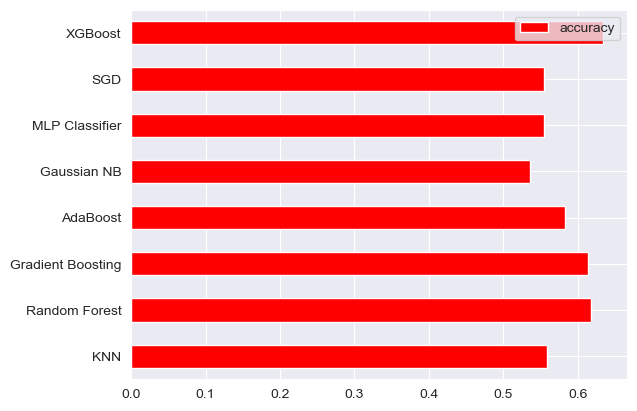

In [210]:
# Affichage des résultats
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.barh(color='red');

## Optimisation des modèles

In [211]:
# Importation des librairies
from sklearn.model_selection import GridSearchCV, KFold

In [ ]:
# Optimisation du model XGBoost
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)


In [ ]:
# Optimisation des modèles
gs2.best_params_

In [ ]:
# Creation des meilleurs paramètres
ideal_model_xgb = XGBClassifier(n_estimators=510,
                                        min_samples_split=2,
                                        min_samples_leaf=3,
                                        max_depth=None,
                                        max_features=0.5,
                                        max_samples=10000,
                                        n_jobs=-1)
ideal_model_xgb.fit(X_train, y_train)
train_score = ideal_model_xgb.score(X_train, y_train)
valid_score = ideal_model_xgb.score(X_valid, y_valid)

print("Précision sur l'ensemble d'entraînement : {:.2f}%".format(train_score * 100))
print("Précision sur l'ensemble de validation : {:.2f}%".format(valid_score * 100))

In [ ]:
ideal_model_xgb.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import RocCurveDisplay

validation = X_valid
prediction = ideal_model_xgb.predict(validation)

In [ ]:
RocCurveDisplay.from_estimator(ideal_model_xgb, X_valid, y_valid)

In [ ]:
RocCurveDisplay.from_estimator(ideal_model_xgb, X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, prediction))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcul de la matrice de confusion
cm = confusion_matrix(y_valid, prediction)

# heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()